In [ ]:
!pip install adversarial-robustness-toolbox
# !pip install adversarial-robustness-toolbox --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.9 MB/s eta 0:00:00


In [ ]:
import time
import numpy as np
import torch.nn as nn
from datetime import datetime

from PIL import Image
from torchvision import transforms
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

from art.estimators.classification import PyTorchClassifier
from skimage.metrics import structural_similarity as ssim

import warnings
warnings.filterwarnings('ignore')
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import FastGradientMethod


In [ ]:
def softmax_activation(inputs):
    inputs = inputs.tolist()
    exp_values = np.exp(inputs - np.max(inputs))

    # Normalize
    probabilities = exp_values / np.sum(exp_values)
    return probabilities

In [ ]:
def compare_images(imageA, imageB):
    return 1 - ssim(imageA, imageB, multichannel=True)
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [ ]:
# model_resnet18 = models.resnet18(pretrained=True)
# model_resnet50 = models.resnet50(pretrained=True)
# model_resnet152 = models.resnet152(pretrained=True)
model_densenet = models.densenet121(pretrained=True)
# model_densenet201 = models.densenet201(pretrained=True)
# model_inception_v3 = models.inception_v3(pretrained=True)
# model_vgg11 = models.vgg11(pretrained=True)
# model_vgg16 = models.vgg16(pretrained=True)
# model_mobilenet_v2 = models.mobilenet_v2(pretrained=True)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 32.5MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()

# Create the ART classifier

classifier = PyTorchClassifier(
    model=model_densenet,
    loss=criterion,
    input_shape=(3, 224, 224),
    nb_classes=1000,
    device_type='gpu'
)

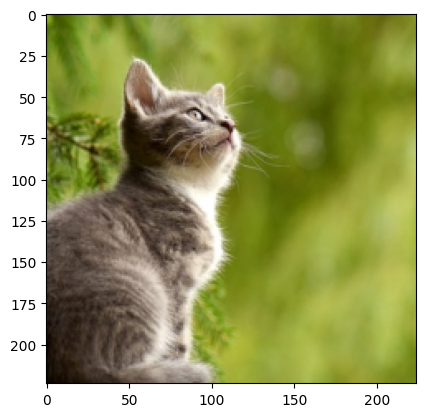

In [ ]:





# import requests
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image

# # Load ImageNet class labels
# url_labels = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
# response = requests.get(url_labels)
# labels = response.json()

# # Choose a random ImageNet class
# class_id = np.random.randint(0, 999)  # ImageNet has 1000 classes
# class_label = labels[class_id]

# # Display the class label
# print("Random ImageNet class label:", class_label)

# # Load an example image corresponding to the selected class
# url_base = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/images/imagenet/"
# url_image = f"{url_base}{class_id}.jpeg"
# input_image = Image.open(requests.get(url_image, stream=True).raw)

# # Display the image
# plt.imshow(input_image)
# plt.axis('off')
# plt.show()




import requests
# url = "https://raw.githubusercontent.com/fukashi-hatake/kaggle_notebooks/main/images/giant_panda.jpg"

# input_image = Image.open(requests.get(url, stream=True).raw)

url = "/content/crab.jpeg"
input_image = Image.open(url)



input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).numpy().astype(np.float32)

input = input_batch[0].transpose((1,2,0))
plt.imshow(input)

In [ ]:
preds = classifier.predict(input_batch)
print(np.argmax(preds, axis=1))

accuracy = np.max(softmax_activation(preds), axis=1)
accuracy = round(accuracy[0], 2)
print("Accuracy on benign examples: {}%".format(accuracy * 100))

[125]
Accuracy on benign examples: 100.0%


In [ ]:
fgsm_attack = FastGradientMethod(estimator = classifier, eps=0.05)

start = time.time()
x_test_adv = fgsm_attack.generate(x=input_batch)
print("Time for attack (in seconds): {}".format(time.time()-start))

Time for attack (in seconds): 0.624629020690918


[125]
Accuracy on adversarial test examples: 68.08%


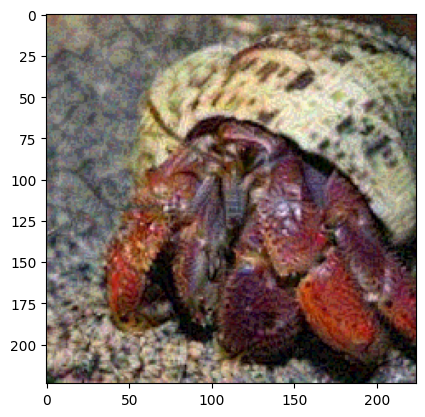

In [ ]:
predictions = classifier.predict(x_test_adv)
print(np.argmax(predictions, axis=1))

accuracy = round(np.max(softmax_activation(predictions), axis=1)[0]*100,2)
print("Accuracy on adversarial test examples: {}%".format(accuracy))

input = x_test_adv[0].transpose((1,2,0))
plt.imshow(input)

In [ ]:
noise = compare_images(input_batch[0].transpose(1,2,0), x_test_adv[0].transpose(1,2,0))
print("Amount of noise: {}".format(noise))

Amount of noise: 0.16273897886276245


In [ ]:
pgd_attack = ProjectedGradientDescent(classifier, max_iter=20, eps_step=1, eps=0.05)

start = time.time()
x_test_adv = pgd_attack.generate(x=input_batch)
print("Time for attack (in seconds): {}".format(time.time()-start))

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Time for attack (in seconds): 2.2750155925750732


[125]
Accuracy on adversarial test examples: 99.99%


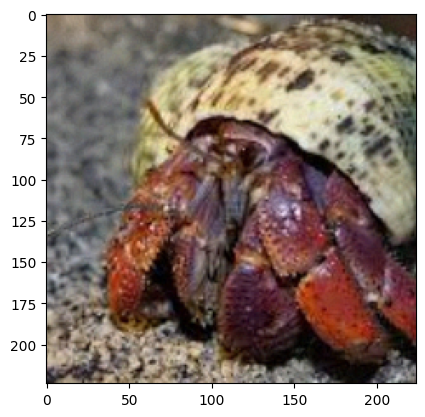

In [ ]:
predictions = classifier.predict(x_test_adv)
print(np.argmax(predictions, axis=1))

accuracy = round(np.max(softmax_activation(predictions), axis=1)[0]*100,2)
print("Accuracy on adversarial test examples: {}%".format(accuracy))

input = x_test_adv[0].transpose((1,2,0))
plt.imshow(input)

In [ ]:
noise = compare_images(input_batch[0].transpose(1,2,0), x_test_adv[0].transpose(1,2,0))
print("Amount of noise: {}".format(noise))

Amount of noise: 0.008366584777832031


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Time for attack (in seconds): 0.48
Predicted class for adversarial example: [533]
Accuracy on adversarial test examples: 100.0%


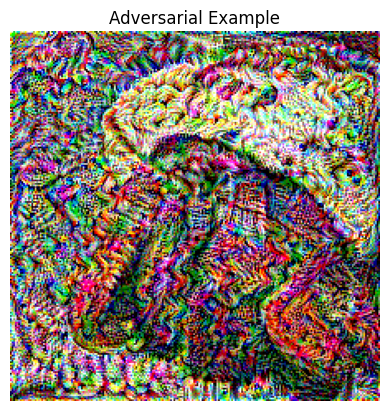

Amount of noise: 0.82


In [ ]:
from art.attacks.evasion import BasicIterativeMethod

# Define the parameters for the Basic Iterative Method (BIM) attack
eps = 0.5  # Maximum perturbation allowed
eps_step = 0.1  # Step size for each iteration
max_iter = 20  # Maximum number of iterations

# Create a BIM attack instance with the specified parameters
bim_attack = BasicIterativeMethod(classifier, eps=eps, eps_step=eps_step, max_iter=max_iter)

# Measure the time taken for the attack
start_time = time.time()

# Generate adversarial examples
x_test_adv = bim_attack.generate(x=input_batch)

# Calculate the time taken for the attack
attack_time = time.time() - start_time
print("Time for attack (in seconds): {:.2f}".format(attack_time))

# Get predictions on the adversarial examples
predictions = classifier.predict(x_test_adv)
predicted_class = np.argmax(predictions, axis=1)
print("Predicted class for adversarial example:", predicted_class)

# Calculate the accuracy on adversarial test examples
accuracy = round(np.max(softmax_activation(predictions), axis=1)[0] * 100, 2)
print("Accuracy on adversarial test examples: {}%".format(accuracy))

# Display the adversarial example
adversarial_image = x_test_adv[0].transpose((1, 2, 0))
plt.imshow(adversarial_image)
plt.title("Adversarial Example")
plt.axis('off')
plt.show()

# Calculate the amount of noise added to the original image
noise = compare_images(input_batch[0].transpose(1, 2, 0), adversarial_image)
print("Amount of noise: {:.2f}".format(noise))


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Time for DeepFool attack (in seconds): 0.48
Predicted class for adversarial example (DeepFool): [125]
Accuracy on adversarial test examples (DeepFool): 60.79%


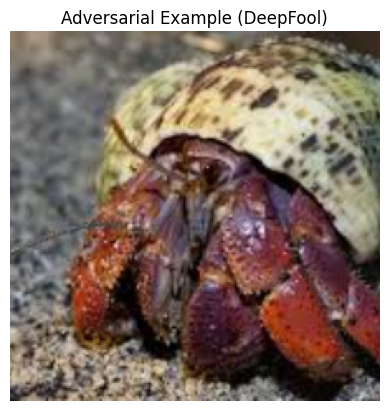

Amount of noise (DeepFool): 0.00


In [ ]:
from art.attacks.evasion import DeepFool

# Define the DeepFool attack instance
deepfool_attack = DeepFool(classifier)

# Measure the time taken for the DeepFool attack
start_time_deepfool = time.time()

# Generate adversarial examples using DeepFool
x_test_adv_deepfool = deepfool_attack.generate(x=input_batch)

# Calculate the time taken for the DeepFool attack
attack_time_deepfool = time.time() - start_time_deepfool
print("Time for DeepFool attack (in seconds): {:.2f}".format(attack_time_deepfool))

# Get predictions on the adversarial examples generated using DeepFool
predictions_deepfool = classifier.predict(x_test_adv_deepfool)
predicted_class_deepfool = np.argmax(predictions_deepfool, axis=1)
print("Predicted class for adversarial example (DeepFool):", predicted_class_deepfool)

# Calculate the accuracy on adversarial test examples using DeepFool
accuracy_deepfool = round(np.max(softmax_activation(predictions_deepfool), axis=1)[0] * 100, 2)
print("Accuracy on adversarial test examples (DeepFool): {}%".format(accuracy_deepfool))

# Display the adversarial example generated using DeepFool
adversarial_image_deepfool = x_test_adv_deepfool[0].transpose((1, 2, 0))
plt.imshow(adversarial_image_deepfool)
plt.title("Adversarial Example (DeepFool)")
plt.axis('off')
plt.show()

# Calculate the amount of noise added to the original image by DeepFool
noise_deepfool = compare_images(input_batch[0].transpose(1, 2, 0), adversarial_image_deepfool)
print("Amount of noise (DeepFool): {:.2f}".format(noise_deepfool))


In [ ]:
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, SaliencyMapMethod

# Define the classifiers for each attack method
classifier_fgm = PyTorchClassifier(model=model_vgg11, loss=criterion, input_shape=(3, 224, 224), nb_classes=1000, device_type='gpu')
classifier_pgd = PyTorchClassifier(model=model_vgg11, loss=criterion, input_shape=(3, 224, 224), nb_classes=1000, device_type='gpu')
classifier_jsma = PyTorchClassifier(model=model_vgg11, loss=criterion, input_shape=(3, 224, 224), nb_classes=1000, device_type='gpu')

# Define the attack instances for each method
attack_fgm = FastGradientMethod(classifier_fgm)
attack_pgd = ProjectedGradientDescent(classifier_pgd)
attack_jsma = SaliencyMapMethod(classifier_jsma)

# Generate adversarial examples using each attack method
x_test_adv_fgm = attack_fgm.generate(x=input_batch)
x_test_adv_pgd = attack_pgd.generate(x=input_batch)
x_test_adv_jsma = attack_jsma.generate(x=input_batch)

# Combine the adversarial examples from different attack methods (Hellocination Attack)
x_test_adv_hellocination = (x_test_adv_fgm + x_test_adv_pgd + x_test_adv_jsma) / 3

# Evaluate the Hellocination Attack adversarial examples
predictions_hellocination = classifier.predict(x_test_adv_hellocination)
accuracy_hellocination = round(np.max(softmax_activation(predictions_hellocination), axis=1)[0] * 100, 2)
print("Accuracy on adversarial test examples (Hellocination Attack): {}%".format(accuracy_hellocination))


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

JSMA:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy on adversarial test examples (Hellocination Attack): 100.0%


In [ ]:
import numpy as np
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, BasicIterativeMethod

def weighted_ensemble_attack(attacks, input_batch, weights=None):
    """
    Combine adversarial examples generated by different attack methods using weighted averaging.

    Args:
        attacks (list): List of adversarial examples generated by different attack methods.
        input_batch (numpy.ndarray): Original input images.
        weights (list, optional): Weights assigned to each attack method for averaging.
                                  If None, equal weights are assigned to each attack method.
                                  Defaults to None.

    Returns:
        numpy.ndarray: Combined adversarial examples.
    """
    num_attacks = len(attacks)
    if weights is None:
        weights = [1 / num_attacks] * num_attacks  # Equal weights if not provided

    combined_attack = np.zeros_like(input_batch)
    for i in range(num_attacks):
        combined_attack += attacks[i] * weights[i]

    return combined_attack

# Instantiate the pre-trained classifier (classifier) and define the input_batch

# Define the Fast Gradient Method (FGM) attack
fgm_attack = FastGradientMethod(estimator=classifier, eps=0.1)

# Define the Projected Gradient Descent (PGD) attack
pgd_attack = ProjectedGradientDescent(estimator=classifier, eps=0.3, eps_step=0.1, max_iter=40)

# Define the Basic Iterative Method (BIM) attack
bim_attack = BasicIterativeMethod(estimator=classifier, eps=0.2, eps_step=0.05, max_iter=30)

# Generate adversarial examples using the defined attack methods
fgm_adv_examples = fgm_attack.generate(x=input_batch)
pgd_adv_examples = pgd_attack.generate(x=input_batch)
bim_adv_examples = bim_attack.generate(x=input_batch)

# Combine the adversarial examples using weighted ensemble attack
attacks = [fgm_adv_examples, pgd_adv_examples, bim_adv_examples]
weights = [0.4, 0.3, 0.3]  # Assigning weights to each attack method
combined_attack = weighted_ensemble_attack(attacks, input_batch, weights)


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Get predictions on the combined adversarial examples
predictions_combined = classifier.predict(combined_attack)

# Calculate the accuracy on adversarial test examples
accuracy_combined = np.max(softmax_activation(predictions_combined), axis=1)[0] * 100
print("Accuracy on adversarial test examples (combined attack): {:.2f}%".format(accuracy_combined))


Accuracy on adversarial test examples (combined attack): 92.86%


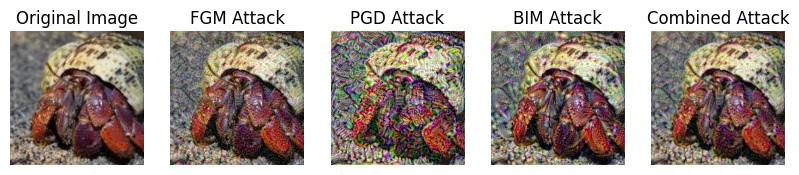

In [ ]:
import matplotlib.pyplot as plt

# Define a function to display images
def display_images(images, titles):
    num_images = len(images)
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Display the original image and the adversarial examples
titles = ['Original Image', 'FGM Attack', 'PGD Attack', 'BIM Attack', 'Combined Attack']
images = [input_batch[0].transpose((1, 2, 0)),
          fgm_adv_examples[0].transpose((1, 2, 0)),
          pgd_adv_examples[0].transpose((1, 2, 0)),
          bim_adv_examples[0].transpose((1, 2, 0)),
          combined_attack[0].transpose((1, 2, 0))]

display_images(images, titles)


In [ ]:
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, SaliencyMapMethod, AdversarialNoise, SpatialTransformation
from art.attacks.evasion.iterative_method import BasicIterativeMethod
from art.estimators.classification import EnsembleClassifier

# Define the classifiers for each attack method
classifier_fgm = PyTorchClassifier(model=model_vgg11, loss=criterion, input_shape=(3, 224, 224), nb_classes=1000, device_type='gpu')
classifier_pgd = PyTorchClassifier(model=model_vgg11, loss=criterion, input_shape=(3, 224, 224), nb_classes=1000, device_type='gpu')
classifier_jsma = PyTorchClassifier(model=model_vgg11, loss=criterion, input_shape=(3, 224, 224), nb_classes=1000, device_type='gpu')

# Define the attack instances for each method
attack_fgm = FastGradientMethod(classifier_fgm)
attack_pgd = ProjectedGradientDescent(classifier_pgd)
attack_jsma = SaliencyMapMethod(classifier_jsma)

# Define additional attack layers
attack_noise = AdversarialNoise()
attack_transform = SpatialTransformation()

# Generate adversarial examples using each attack method with different parameters
x_test_adv_fgm = attack_fgm.generate(x=input_batch, eps=0.1, eps_step=0.01, max_iter=50)
x_test_adv_pgd = attack_pgd.generate(x=input_batch, eps=0.3, eps_step=0.03, max_iter=100)
x_test_adv_jsma = attack_jsma.generate(x=input_batch, theta=0.1)

# Apply additional attack layers iteratively
attack_iterative = BasicIterativeMethod(classifier=classifier_fgm, eps=0.01, eps_step=0.005, max_iter=10)
x_test_adv_iterative = attack_iterative.generate(x=input_batch)

# Combine the adversarial examples from different attack methods with an ensemble classifier
ensemble_classifier = EnsembleClassifier(classifiers=[classifier_fgm, classifier_pgd, classifier_jsma])
x_test_adv_combined = ensemble_classifier.predict(x=input_batch)

# Evaluate the combined adversarial examples
predictions_combined = ensemble_classifier.predict(x=input_batch)
accuracy_combined = round(np.max(softmax_activation(predictions_combined), axis=1)[0] * 100, 2)
print("Accuracy on adversarial test examples (Combined Attack): {}%".format(accuracy_combined))


ImportError: cannot import name 'AdversarialNoise' from 'art.attacks.evasion' (/usr/local/lib/python3.10/dist-packages/art/attacks/evasion/__init__.py)